In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import altair as alt
import time
import sklearn
import warnings
import pickle
import catboost


warnings.filterwarnings(action="ignore", category=FutureWarning)

pd.__version__, sklearn.__version__, catboost.__version__

('2.1.1', '1.3.1', '1.2.2')

In [6]:
SCRATCH_DIR = "/scratch/siads696f23_class_root/siads696f23_class/psollars"

# For local dev
SCRATCH_DIR = "./../data"

In [7]:
# Checkpoint

DATASET = "19_consolidated_all_delays"

with open(f"{SCRATCH_DIR}/{DATASET}_X_res.pkl", "rb") as f:
    X_res = pickle.load(f)

with open(f"{SCRATCH_DIR}/{DATASET}_y_res.pkl", "rb") as f:
    y_res = pickle.load(f)

with open(f"{SCRATCH_DIR}/{DATASET}_X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open(f"{SCRATCH_DIR}/{DATASET}_y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

In [10]:
# CatBoost is converting True/False into string values for some reason
# casting the labels as 1/0 ints here
y_res = y_res.astype(int)
y_test = y_test.astype(int)

In [12]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score


def fit_grid_search(fit_X_train, fit_y_train):
    cat_classifier = CatBoostClassifier(
        eval_metric="F1", auto_class_weights="Balanced", verbose=0
    )

    # Start balanced
    f_beta_scorer = make_scorer(fbeta_score, beta=1)

    # Attempt to increase precision
    # f_beta_scorer = make_scorer(fbeta_score, beta=0.5)

    grid_search = GridSearchCV(
        estimator=cat_classifier,
        param_grid={
            # "learning_rate": [0.001, 0.01, 0.1, 0.2],
            # "depth": [6, 8, 10],
            # "iterations": [100, 200],
            # "l2_leaf_reg": [1, 3, 5],
        },
        scoring=f_beta_scorer,
        verbose=3,
        cv=5,
        n_jobs=-1,
    )

    grid_search.fit(fit_X_train, fit_y_train)

    return grid_search


start_time = time.time()

model = fit_grid_search(X_res, y_res)

end_time = time.time()

print(f"Elapsed time: {(end_time - start_time):.4f} seconds")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 5/5] END ..................................., score=0.971 total time=23.3min
[CV 4/5] END ..................................., score=0.970 total time=23.4min
[CV 3/5] END ..................................., score=0.971 total time=23.4min
[CV 2/5] END ..................................., score=0.677 total time=23.4min
[CV 1/5] END ..................................., score=0.067 total time=23.4min
Elapsed time: 1776.0814 seconds


In [34]:
# Checkpoint

MODEL_NAME = "Cat Boost (Default Params, F1 Score)"
MODEL = "19_all_delays_catboost_f1"

with open(f"{SCRATCH_DIR}/{MODEL}_model.pkl", "wb") as f:
    pickle.dump(model, f)

# So we can recompute the metrics later
with open(f"{SCRATCH_DIR}/{MODEL}_X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)
with open(f"{SCRATCH_DIR}/{MODEL}_y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

# with open(f"{SCRATCH_DIR}/{MODEL}_model.pkl", "rb") as f:
#     model = pickle.load(f)

# Model Evaluation

In [35]:
# # Try this model to test on the big data
# # MODEL = "all_delays_catboost_f1"
# MODEL = "model_selection_all_delays_ORD_UA_catboost"

# with open(f"{SCRATCH_DIR}/{MODEL}_model.pkl", "rb") as f:
#     model = pickle.load(f)

# # with open(f"{SCRATCH_DIR}/{MODEL}_X_test.pkl", "rb") as f:
# #     X_test = pickle.load(f)

# # with open(f"{SCRATCH_DIR}/{MODEL}_y_test.pkl", "rb") as f:
# #     y_test = pickle.load(f)

In [36]:
print("Best parameters: ", model.best_params_)
print("Best score: ", model.best_score_)

model.cv_results_

Best parameters:  {}
Best score:  0.731432783025635


{'mean_fit_time': array([1390.15411434]),
 'std_fit_time': array([4.55005437]),
 'mean_score_time': array([12.61647215]),
 'std_score_time': array([2.91913771]),
 'params': [{}],
 'split0_test_score': array([0.06738273]),
 'split1_test_score': array([0.67722444]),
 'split2_test_score': array([0.97142762]),
 'split3_test_score': array([0.97034156]),
 'split4_test_score': array([0.97078756]),
 'mean_test_score': array([0.73143278]),
 'std_test_score': array([0.35096058]),
 'rank_test_score': array([1], dtype=int32)}

In [37]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)


y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:, 1]

[[388509  12675]
 [100793  23260]]


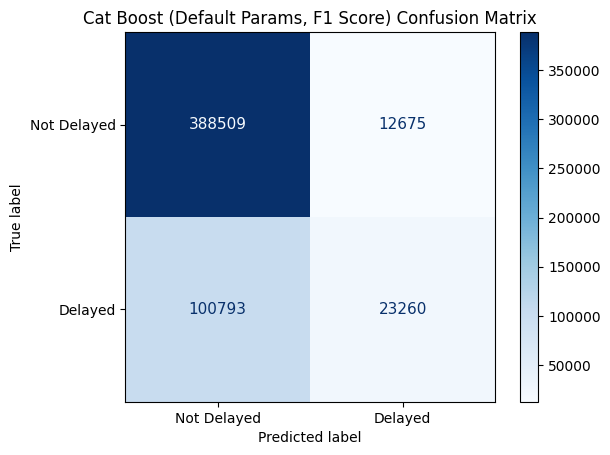

In [38]:
cm = confusion_matrix(y_test, y_pred)

print(cm)

cmd = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Delayed", "Delayed"]
)

cmd.plot(cmap="Blues")
plt.title(f"{MODEL_NAME} Confusion Matrix")

ax = plt.gca()
for i in range(len(cm)):
    for j in range(len(cm[i])):
        text = ax.texts[i * len(cm) + j]
        text.set_text(str(cm[i][j]))
        text.set_size(11)

plt.savefig(f"./visualizations/{MODEL}_cm.png")

plt.show()


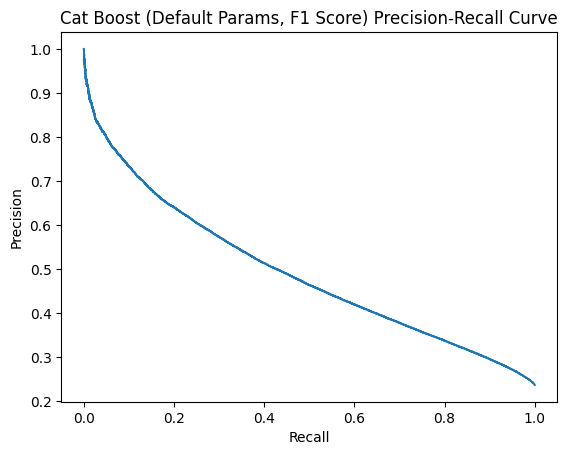

In [39]:
precision, recall, _ = precision_recall_curve(y_test, y_scores)

plt.figure()
plt.step(recall, precision, where="post")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"{MODEL_NAME} Precision-Recall Curve")

plt.savefig(f"./visualizations/{MODEL}_pr.png")

plt.show()

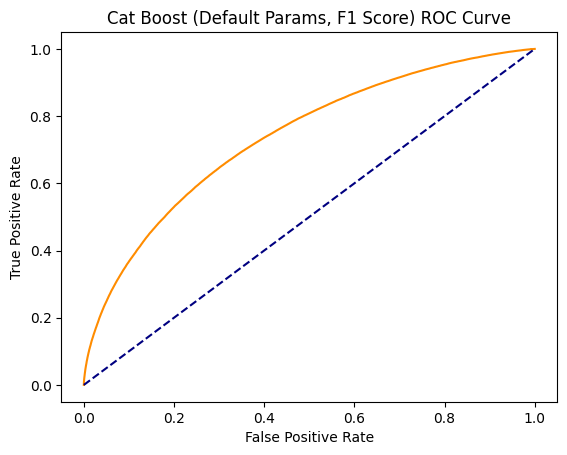

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve")
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"{MODEL_NAME} ROC Curve")

plt.savefig(f"./visualizations/{MODEL}_roc.png")

plt.show()

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred, average="macro", multi_class="ovr")

accuracy, precision, recall, f1, roc_auc

(0.7839679992079766,
 0.6472798107694449,
 0.18750050381691696,
 0.2907718078855914,
 0.577953261001543)

In [42]:
metrics_scores = {
    "Accuracy": accuracy,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "ROC AUC": roc_auc,
}

df_metrics = pd.DataFrame(list(metrics_scores.items()), columns=["Metric", "Score"])

base = alt.Chart(df_metrics).encode(
    y=alt.Y("Metric:N", axis=alt.Axis(title="Metric"), sort=df_metrics["Metric"].values),
    x=alt.X("Score:Q", axis=alt.Axis(title="Score"), scale=alt.Scale(domain=[0, 1])),
)

bar = base.mark_bar().encode(
    color=alt.Color("Metric:N", legend=None), text=alt.Text("Score:Q", format=".2f")
)

text = base.mark_text(
    align="right",
    baseline="middle",
    color="white",
    dx=-10,
).encode(text=alt.Text("Score:Q", format=".2f"))

chart = (
    (bar + text)
    .properties(title=f"{MODEL_NAME} Evaluation Metrics", width=600, height=300)
    .configure_axis(labelFontSize=12, titleFontSize=14)
)

# Can't get this one to save programmatically :(
# from altair_saver import save
# chart.save(f"./visualizations/{MODEL}_metrics.png")
# save(chart, f"./visualizations/{MODEL}_metrics.png")

chart

alt.LayerChart(...)